## Some params

In [4]:
GPU_NUMBER="3"
NUM_LABELS=7
LABELS=["airplane",
        "face",
        "knife",
        "motorbike",
        "other",
        "pistol",
        "NA"]
NET_NAME="net"
TRAINED_CHECKPOINT="gs://alex-s2t-test/adversarial/nets_ckpt/inception_resnet_v2_2016_08_30.ckpt"
TRANSFER_LEARNING_CHECKPOINT="gs://alex-s2t-test/adversarial/datasets/six_labels/inception_resnet/training/train/model.ckpt-1000"

## Cleanup

In [5]:
%%bash
rm -rf resources

## Setup

In [6]:
import os
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

In [7]:
with tf.device("/device:GPU:"+GPU_NUMBER):
    tf.logging.set_verbosity(tf.logging.ERROR)
    sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True))

First, we set up the input image. We use a tf.Variable instead of a tf.placeholder because we will need it to be trainable. We can still feed it when we want to.

In [8]:
with tf.device("/device:GPU:"+GPU_NUMBER):
    image = tf.Variable(tf.zeros((299, 299, 3)))

## Building retrained inception resnet

In [9]:
from trainer.inception_resnet_v2_builder import InceptionResnetV2Builder as ModelBuilder
modelBuilder = ModelBuilder()

In [10]:
def load_body_checkpoint(session, checkpoint_path):
    variables_to_exclude_from_scope = ModelBuilder.CHECKPOINT_VARIABLES_TO_EXCLUDE_FROM_SCOPE
    all_vars = tf.contrib.slim.get_variables_to_restore(
        exclude=variables_to_exclude_from_scope
    )

    reader = tf.train.NewCheckpointReader(checkpoint_path)
    var_to_shape_map = reader.get_variable_to_shape_map()
    inception_vars = {
        var.op.name: var
        for var in all_vars if var.op.name in var_to_shape_map
    }

    saver = tf.train.Saver(inception_vars)
    saver.restore(session, checkpoint_path)
    
def restore_head_checkpoint(session, checkpoint_path, layer1_weights, layer1_biases, layer2_weights, layer2_biases):
    var_list = {
        "InceptionResnetV2/NewLogits/fully_connected/weights" : layer1_weights,
        "InceptionResnetV2/NewLogits/fully_connected/biases" : layer1_biases,
        "InceptionResnetV2/NewLogits/fully_connected_1/weights" : layer2_weights,
        "InceptionResnetV2/NewLogits/fully_connected_1/biases" : layer2_biases
    }
    saver = tf.train.Saver(var_list=var_list)
    saver.restore(session, checkpoint_path)  

def build_head(embeddings, num_labels, scope, reuse=False):
    #print num_labels
    softmax, endpoints, ordered_endpoints = ModelBuilder().build_predict_model(embeddings, 
        num_classes=num_labels,
        final_endpoint="PreLogitsFlatten",
        final_layer_type="Softmax",
        reverse=True,
        scope=scope,
        reuse=reuse
    )
    #print softmax.get_shape().as_list()
    with tf.name_scope(scope+"/prediction"):
        prediction = tf.argmax(softmax, 1)
    
    weights = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope)
    for w in weights:
        if "fully_connected/weights" in w.name:
            fc_weights=w
        if "fully_connected/biases" in w.name:
            fc_biases=w
        if "fully_connected_1/weights" in w.name:
            fc1_weights=w
        if "fully_connected_1/biases" in w.name:
            fc1_biases=w
    
    return endpoints["Logits"], softmax, prediction, fc_weights, fc_biases, fc1_weights, fc1_biases

def build_inception_resnet(images, reuse=False):

    print("building body..")
    embeddings, end_points, ordered_end_points = modelBuilder.build_predict_model(
        images, num_classes=NUM_LABELS, final_endpoint='PreLogitsFlatten', reuse=reuse)
    
    
    weights={}

    print("building heads...")
    logits, softmax, prediction, fc_weights, fc_biases, fc1_weights, fc1_biases = build_head(
        embeddings, NUM_LABELS, NET_NAME, reuse
    )
    weights={
        "softmax":softmax,
        "prediction":prediction,
        "fc_weights":fc_weights,
        "fc_biases":fc_biases,
        "fc1_weights":fc1_weights,
        "fc1_biases":fc1_biases
    }

    outputs={}    
    w = weights

    if not reuse:
        print("loading body checkpoint...")
        load_body_checkpoint(sess, TRAINED_CHECKPOINT)
        print("loading heads checkpoints...")


        restore_head_checkpoint(
            sess, 
            TRANSFER_LEARNING_CHECKPOINT, 
            w["fc_weights"],
            w["fc_biases"],
            w["fc1_weights"],
            w["fc1_biases"]
        )
    outputs["prediction"]=w["prediction"]
    outputs["scores"]=w["softmax"]

    return logits, outputs["scores"]

In [11]:
def inception(image, reuse):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v3(
            preprocessed, 1001, is_training=False, reuse=reuse)
        logits = logits[:,1:] # ignore background class
        probs = tf.nn.softmax(logits) # probabilities
    return logits, probs

#logits, probs = inception(image, reuse=False)

In [12]:
def inception_resnet(image, reuse=False):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    logits, probs=build_inception_resnet(preprocessed, reuse=reuse)
    return logits, probs

#logits, probs = inception_resnet(image)

In [13]:
with tf.device("/device:GPU:"+GPU_NUMBER):
    logits, probs = inception_resnet(image)

building body..
building heads...
loading body checkpoint...
loading heads checkpoints...


In [14]:
import json
import matplotlib.pyplot as plt

In [15]:
#imagenet_json="resources/imagenet.json"
#with open(imagenet_json) as f:
#    imagenet_labels = json.load(f)

In [16]:
def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={image: img})[0]
    ax1.imshow(img)
    fig.sca(ax1)
    
    topk = list(p.argsort()[-NUM_LABELS:][::-1])
    print(topk)
    topprobs = p[topk]
    barlist = ax2.bar(range(NUM_LABELS), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(NUM_LABELS),
               [LABELS[i] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

## Example image

In [21]:
from PIL import Image
import numpy as np

In [22]:
%%bash
wget 'https://cdn.shopify.com/s/files/1/0276/1899/products/AK-47-Assault-Rifle_large.jpg?v=1387091633' -P resources -O rifle.jpg
tar -xf resources/inception_v3_2016_08_28.tar.gz -C resources

--2018-06-19 12:30:23--  https://cdn.shopify.com/s/files/1/0276/1899/products/AK-47-Assault-Rifle_large.jpg?v=1387091633
Resolving cdn.shopify.com (cdn.shopify.com)... 23.211.8.46, 2a04:4e42::622, 2a04:4e42:200::622, ...
Connecting to cdn.shopify.com (cdn.shopify.com)|23.211.8.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10086 (9.8K) [image/jpeg]
Saving to: ‘rifle.jpg’

     0K .........                                             100%  127M=0s

2018-06-19 12:30:23 (127 MB/s) - ‘rifle.jpg’ saved [10086/10086]

tar: resources/inception_v3_2016_08_28.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [23]:
img_path = 'rifle.jpg'
img_class = LABELS.index("pistol")
img = Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img = (np.asarray(img) / 255.0).astype(np.float32)

[5, 4, 1, 2, 3, 6, 0]


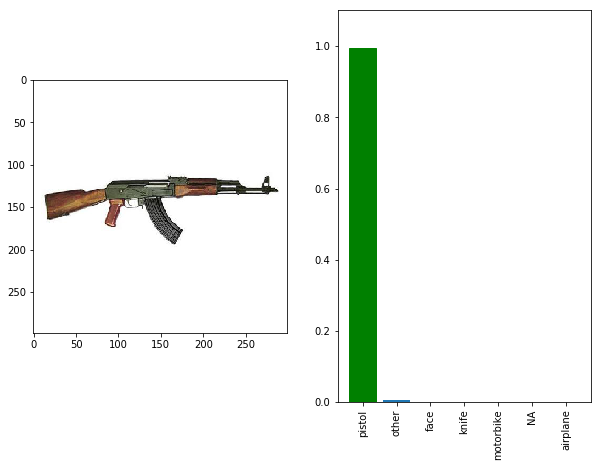

In [24]:
classify(img, correct_class=img_class)

# Adversarial examples

In [25]:
with tf.device("/device:GPU:"+GPU_NUMBER):
    x = tf.placeholder(tf.float32, (299, 299, 3))

    x_hat = image # our trainable adversarial input
    assign_op = tf.assign(x_hat, x)
    
    learning_rate = tf.placeholder(tf.float32, ())
    y_hat = tf.placeholder(tf.int32, ())

    labels = tf.one_hot(y_hat, NUM_LABELS)
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
    optim_step = tf.train.GradientDescentOptimizer(
        learning_rate).minimize(loss, var_list=[x_hat])
    
    epsilon = tf.placeholder(tf.float32, ())

    below = x - epsilon
    above = x + epsilon
    projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
    with tf.control_dependencies([projected]):
        project_step = tf.assign(x_hat, projected)

In [41]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-3
demo_steps = 10000
demo_target = LABELS.index("motorbike")#3 # "knife"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv = x_hat.eval() # retrieve the adversarial example

step 10, loss=9.13709
step 20, loss=9.01703
step 30, loss=8.94861
step 40, loss=8.8842
step 50, loss=8.82531
step 60, loss=8.79592
step 70, loss=8.75112
step 80, loss=8.70072
step 90, loss=8.65742
step 100, loss=8.62372
step 110, loss=8.58761
step 120, loss=8.5429
step 130, loss=8.51316
step 140, loss=8.4821
step 150, loss=8.4663
step 160, loss=8.43058
step 170, loss=8.4067
step 180, loss=8.3688
step 190, loss=8.34081
step 200, loss=8.32798
step 210, loss=8.32834
step 220, loss=8.29289
step 230, loss=8.27371
step 240, loss=8.25162
step 250, loss=8.23362
step 260, loss=8.2281
step 270, loss=8.21392
step 280, loss=8.17666
step 290, loss=8.17649
step 300, loss=8.17211
step 310, loss=8.13919
step 320, loss=8.12698
step 330, loss=8.11677
step 340, loss=8.09521
step 350, loss=8.10397
step 360, loss=8.05755
step 370, loss=8.05816
step 380, loss=8.02396
step 390, loss=8.03745
step 400, loss=8.00704
step 410, loss=7.98738
step 420, loss=7.95368
step 430, loss=7.91139
step 440, loss=7.8719
step 

step 3490, loss=6.05643
step 3500, loss=6.039
step 3510, loss=6.03367
step 3520, loss=5.99583
step 3530, loss=6.0502
step 3540, loss=6.00482
step 3550, loss=5.99332
step 3560, loss=6.01582
step 3570, loss=6.0367
step 3580, loss=6.00208
step 3590, loss=5.99378
step 3600, loss=6.01007
step 3610, loss=6.00307
step 3620, loss=6.01193
step 3630, loss=6.0063
step 3640, loss=5.99278
step 3650, loss=5.9795
step 3660, loss=5.99681
step 3670, loss=6.00236
step 3680, loss=5.98799
step 3690, loss=5.99826
step 3700, loss=5.9743
step 3710, loss=5.95289
step 3720, loss=5.94439
step 3730, loss=5.96248
step 3740, loss=5.92996
step 3750, loss=5.95151
step 3760, loss=5.99109
step 3770, loss=5.96325
step 3780, loss=5.9562
step 3790, loss=5.93487
step 3800, loss=5.95693
step 3810, loss=5.92595
step 3820, loss=5.96661
step 3830, loss=5.93405
step 3840, loss=5.97838
step 3850, loss=5.90816
step 3860, loss=5.92042
step 3870, loss=5.93793
step 3880, loss=5.95049
step 3890, loss=5.97029
step 3900, loss=5.93409


step 6920, loss=5.41782
step 6930, loss=5.4279
step 6940, loss=5.45093
step 6950, loss=5.45099
step 6960, loss=5.43267
step 6970, loss=5.41054
step 6980, loss=5.473
step 6990, loss=5.41057
step 7000, loss=5.43885
step 7010, loss=5.40572
step 7020, loss=5.42555
step 7030, loss=5.41451
step 7040, loss=5.40957
step 7050, loss=5.41292
step 7060, loss=5.44378
step 7070, loss=5.40979
step 7080, loss=5.46704
step 7090, loss=5.40591
step 7100, loss=5.41185
step 7110, loss=5.38392
step 7120, loss=5.40738
step 7130, loss=5.41099
step 7140, loss=5.41071
step 7150, loss=5.43839
step 7160, loss=5.41826
step 7170, loss=5.41822
step 7180, loss=5.42624
step 7190, loss=5.39254
step 7200, loss=5.38497
step 7210, loss=5.4045
step 7220, loss=5.41142
step 7230, loss=5.37049
step 7240, loss=5.40255
step 7250, loss=5.42825
step 7260, loss=5.38194
step 7270, loss=5.4229
step 7280, loss=5.38616
step 7290, loss=5.45082
step 7300, loss=5.36183
step 7310, loss=5.36865
step 7320, loss=5.4019
step 7330, loss=5.4069

In [ ]:
classify(adv, correct_class=img_class, target_class=demo_target)

In [33]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
demo_target = LABELS.index("other")#3 # "knife"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv = x_hat.eval() # retrieve the adversarial example

step 10, loss=3.5353
step 20, loss=2.38361
step 30, loss=0.0013314
step 40, loss=0.000531294
step 50, loss=0.00033659
step 60, loss=0.000253168
step 70, loss=0.000201324
step 80, loss=0.000164614
step 90, loss=0.000139346
step 100, loss=0.000120156


[4, 5, 1, 2, 0, 3, 6]


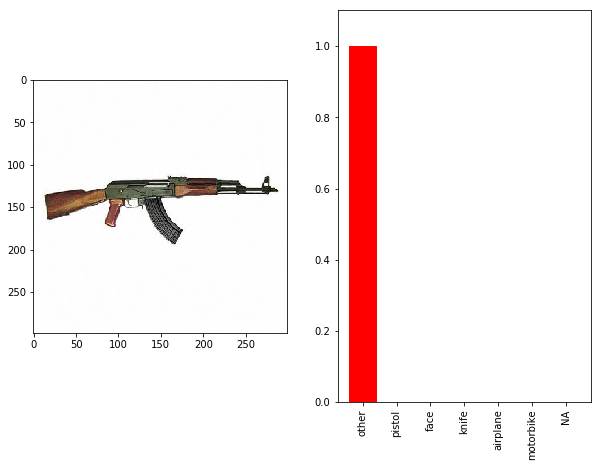

In [34]:
classify(adv, correct_class=img_class, target_class=demo_target)

# Robust adversarial examples

In [33]:
num_samples = 10
average_loss = 0
#with tf.variable_scope("InceptionResnetV2", reuse=True):
for i in range(num_samples):
    print i
    rotated = tf.contrib.image.rotate(
        image, tf.random_uniform((), minval=-np.pi/4, maxval=np.pi/4))
    rotated_logits, _ = inception_resnet(rotated, reuse=True)
    average_loss += tf.nn.softmax_cross_entropy_with_logits(
        logits=rotated_logits, labels=labels) / num_samples

0
building body..
building heads...
1
building body..
building heads...
2
building body..
building heads...
3
building body..
building heads...
4
building body..
building heads...
5
building body..
building heads...
6
building body..
building heads...
7
building body..
building heads...
8
building body..
building heads...
9
building body..
building heads...


In [34]:
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(average_loss, var_list=[x_hat])

In [35]:
demo_epsilon = 8.0/255.0 # still a pretty small perturbation
demo_lr = 2e-1
#demo_steps = 300
#demo_target = 924 # "guacamole"
demo_steps = 1000
demo_target = 3 # "knife"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, average_loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 50 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv_robust = x_hat.eval() # retrieve the adversarial example

step 50, loss=0.00699378
step 100, loss=0.00114555
step 150, loss=0.000906413
step 200, loss=0.000823416
step 250, loss=0.000393062
step 300, loss=0.000225114
step 350, loss=0.000497737
step 400, loss=0.000258964
step 450, loss=0.000219198


KeyboardInterrupt: 

In [ ]:
#adv_robust = x_hat.eval() # retrieve the adversarial example
rotated_example = rotated_image.eval(feed_dict={image: adv_robust, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)

## Evaluation

In [ ]:
thetas = np.linspace(-np.pi/4, np.pi/4, 301)

p_naive = []
p_robust = []
for theta in thetas:
    rotated = rotated_image.eval(feed_dict={image: adv_robust, angle: theta})
    p_robust.append(probs.eval(feed_dict={image: rotated})[0][demo_target])
    
    rotated = rotated_image.eval(feed_dict={image: adv, angle: theta})
    p_naive.append(probs.eval(feed_dict={image: rotated})[0][demo_target])

robust_line, = plt.plot(thetas, p_robust, color='b', linewidth=2, label='robust')
naive_line, = plt.plot(thetas, p_naive, color='r', linewidth=2, label='naive')
plt.ylim([0, 1.05])
plt.xlabel('rotation angle')
plt.ylabel('target class probability')
plt.legend(handles=[robust_line, naive_line], loc='lower right')
plt.show()